<a href="https://colab.research.google.com/github/rich-hyun/5th-Static-Competition/blob/main/static_jaehyun.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. 데이터 불러오기

In [1]:
!pip install scikit-learn
!pip install lightgbm xgboost

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
import json

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
#데이터 시각화

# Load the dataset from the provided URL
url = "https://raw.githubusercontent.com/rich-hyun/5th-Static-Competition/main/Urban%20Air%20Quality%20and%20Health%20Impact%20Dataset.csv"
df = pd.read_csv(url)

# Display the first few rows of the dataset to understand its structure
df.head()


,datetime,datetimeEpoch,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,City,Temp_Range,Heat_Index,Severity_Score,Condition_Code,Month,Season,Day_of_Week,Is_Weekend,Health_Risk_Score
0,2024-09-07,1725692400,106.1,91.0,98.5,104.0,88.1,95.9,51.5,21.0,...,Phoenix,15.1,95.918703,4.4300,NaN,9,Fall,Saturday,True,10.522170
1,2024-09-08,1725778800,103.9,87.0,95.4,100.5,84.7,92.3,48.7,21.5,...,Phoenix,16.9,92.281316,3.8800,0.0,9,Fall,Sunday,True,10.062332
2,2024-09-09,1725865200,105.0,83.9,94.7,99.9,81.6,90.6,41.7,16.9,...,Phoenix,21.1,90.599165,3.6300,0.0,9,Fall,Monday,False,9.673387
3,2024-09-10,1725951600,106.1,81.2,93.9,100.6,79.5,89.8,39.1,15.7,...,Phoenix,24.9,89.638811,2.8512,0.0,9,Fall,Tuesday,False,9.411519
4,2024-09-11,1726038000,106.1,82.1,94.0,101.0,80.0,90.0,40.1,15.9,...,Phoenix,24.0,89.760414,3.3908,0.0,9,Fall,Wednesday,False,9.515179


In [ ]:
# 추가로 제외할 컬럼들 설정 및 모델 정확도 측정 코드 작성
# 특성 및 타겟 데이터 설정 (추가 컬럼 제거)
features_updated = df.drop(columns = ['datetime', 'sunrise', 'sunset', 'preciptype', 'snowdepth', 'stations', 'Condition_Code',
                                      'Health_Risk_Score' ,'conditions', 'description', 'icon', 'source', 'City', 'Season',
                                      'Day_of_Week', 'datetimeEpoch', 'feelslikemin', 'precipprob', 'solarenergy', 'uvindex',
                                      'sunriseEpoch', 'sunsetEpoch', 'moonphase', 'Heat_Index', 'Is_Weekend'])
target = df['Health_Risk_Score']

# 데이터 분할
X_train_updated, X_test_updated, y_train_updated, y_test_updated = train_test_split(features_updated, target, test_size=0.2, random_state=29)

# 데이터 스케일링
scaler_updated = StandardScaler()
X_train_scaled_updated = scaler_updated.fit_transform(X_train_updated)
X_test_scaled_updated = scaler_updated.transform(X_test_updated)

# 랜덤 포레스트 모델 학습
rf_model_updated = RandomForestRegressor(n_estimators=120, random_state=29)
rf_model_updated.fit(X_train_scaled_updated, y_train_updated)

# 예측
y_pred_rf_updated = rf_model_updated.predict(X_test_scaled_updated)

# 정확도 측정 (MAE 및 R2 점수)
mae_rf_updated = mean_absolute_error(y_test_updated, y_pred_rf_updated)
r2_rf_updated = r2_score(y_test_updated, y_pred_rf_updated)

mae_rf_updated, r2_rf_updated

(0.08613055937354183, 0.9654342969476132)

##1.1 선형회귀 모델을 쓰지 못하는 이유

In [ ]:
#상관관계 계산
# 숫자형 데이터만 선택하여 상관관계 계산
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Health_Risk_Score와 다른 변수들 간의 상관관계 계산
correlation_matrix = numeric_df.corr()

# Health_Risk_Score와 다른 변수들 간의 상관관계 높은 순으로 정렬
health_risk_corr_sorted = correlation_matrix["Health_Risk_Score"].sort_values(ascending=False)

# 상관관계 출력
print(health_risk_corr_sorted)

Health_Risk_Score    1.000000
Heat_Index           0.610722
Severity_Score       0.585555
windgust             0.583670
dew                  0.581391
severerisk           0.524030
feelslike            0.522430
feelslikemax         0.518574
windspeed            0.487805
feelslikemin         0.454905
tempmin              0.434786
temp                 0.412288
tempmax              0.354713
precipprob           0.321389
precipcover          0.284049
humidity             0.186211
uvindex              0.173279
precip               0.143755
cloudcover           0.136964
solarradiation       0.085156
solarenergy          0.081934
Temp_Range          -0.056190
moonphase           -0.106345
sunriseEpoch        -0.108654
datetimeEpoch       -0.111190
sunsetEpoch         -0.115130
visibility          -0.176669
winddir             -0.183140
pressure            -0.297056
snow                      NaN
snowdepth                 NaN
Condition_Code            NaN
Month                     NaN
Name: Heal

In [ ]:
#변수들 간의 상관관계 확인->다중공정성 문제
# 선택한 변수들 간의 상관관계 계산
selected_features = ['Heat_Index', 'Severity_Score', 'windgust', 'dew', 'severerisk',
                     'feelslike', 'feelslikemax', 'windspeed', 'feelslikemin',
                     'tempmin', 'temp']

# 선택한 변수들의 상관관계 매트릭스 계산
selected_corr_matrix = df[selected_features].corr()

# 상관관계 매트릭스 출력
print(selected_corr_matrix)

                Heat_Index  Severity_Score  windgust       dew  severerisk  \
Heat_Index        1.000000        0.294434  0.259991  0.072294    0.486072   
Severity_Score    0.294434        1.000000  0.862801 -0.038384    0.073273   
windgust          0.259991        0.862801  1.000000  0.132921    0.082172   
dew               0.072294       -0.038384  0.132921  1.000000    0.392131   
severerisk        0.486072        0.073273  0.082172  0.392131    1.000000   
feelslike         0.827673        0.267552  0.280502  0.288758    0.427733   
feelslikemax      0.815434        0.247352  0.230291  0.262477    0.408079   
windspeed         0.186978        0.689536  0.718891  0.044377    0.073634   
feelslikemin      0.740163        0.230200  0.260073  0.290646    0.387913   
tempmin           0.738725        0.226903  0.251239  0.258251    0.366885   
temp              0.800903        0.275709  0.275448  0.150877    0.343067   

                feelslike  feelslikemax  windspeed  feelslikemi

##1.2 변수들 설명

<ipython-input-27-748571521f82>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feature_names, palette='plasma')


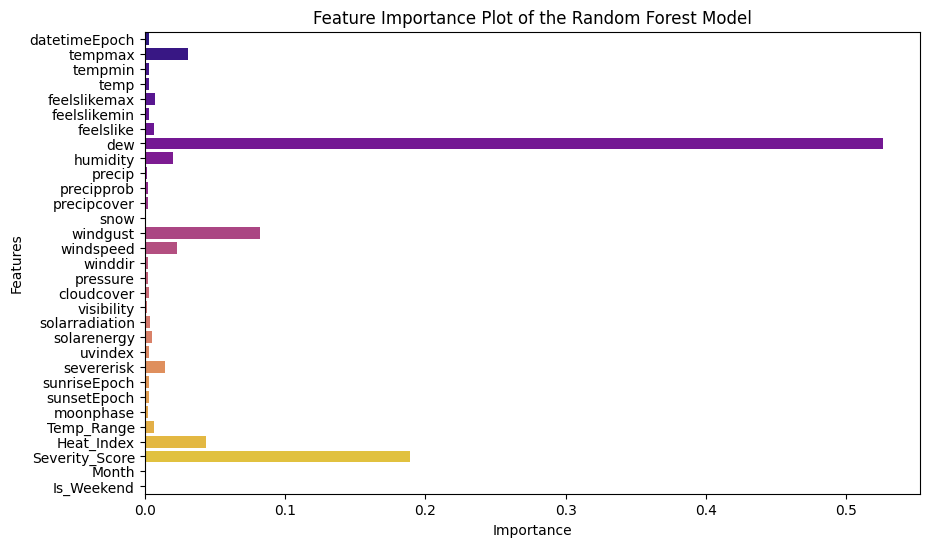

In [ ]:
# 특성 및 타겟 데이터 설정 (분석에서 제외할 컬럼들 제거)
features = df.drop(columns = ['datetime', 'sunrise', 'sunset', 'preciptype', 'snowdepth', 'stations', 'Condition_Code', 'Health_Risk_Score' ,'conditions', 'description', 'icon', 'source', 'City', 'Season', 'Day_of_Week'])
target = df['Health_Risk_Score']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=29)

# 데이터 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 랜덤 포레스트 모델 학습
rf_model = RandomForestRegressor(n_estimators=120, random_state=29)
rf_model.fit(X_train_scaled, y_train)

# 변수 중요도 추출
importances = rf_model.feature_importances_
feature_names = X_train.columns

# 변수 중요도 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names, palette='plasma')
plt.title('Feature Importance Plot of the Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

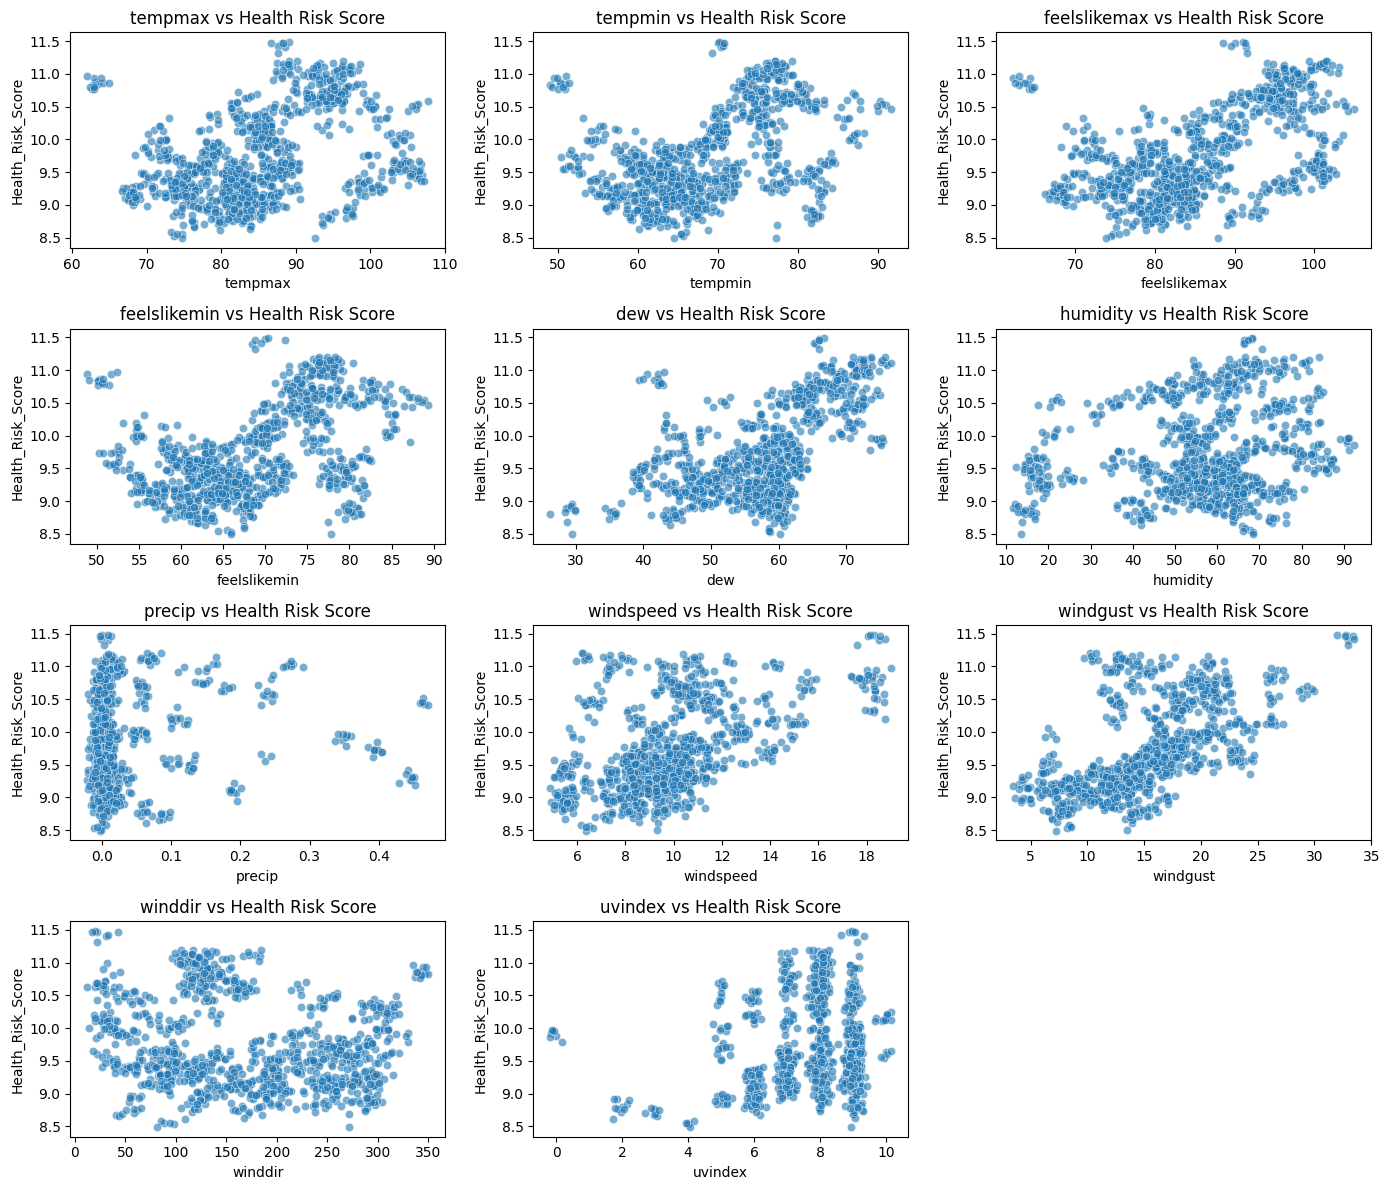

In [ ]:
# 각 변수의 분포도와 Health Risk Score의 관계를 시각화하는 코드
plt.figure(figsize=(14, 12))

# 선택된 주요 변수들
selected_features = ['tempmax', 'tempmin', 'feelslikemax', 'feelslikemin', 'dew',
                     'humidity', 'precip', 'windspeed', 'windgust', 'winddir', 'uvindex']

# 산점도로 각 변수와 Health Risk Score의 관계 시각화
for i, feature in enumerate(selected_features, 1):
    plt.subplot(4, 3, i)
    sns.scatterplot(x=df[feature], y=df['Health_Risk_Score'], alpha=0.6)
    plt.title(f'{feature} vs Health Risk Score')

plt.tight_layout()
plt.show()

#2. 모델 제작

##2.1 랜덤포레스트 모델

In [ ]:
#선별된 데이터의 randomforest 결과

# 특성 및 타겟 데이터 설정 (분석에서 제외할 컬럼들 제거)
features = df.drop(columns = ['datetime', 'sunrise', 'sunset', 'preciptype', 'snowdepth', 'stations', 'Condition_Code', 'Health_Risk_Score' ,'conditions', 'description', 'icon', 'source', 'City', 'Season', 'Day_of_Week'])
target = df['Health_Risk_Score']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=29)

# 데이터 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 랜덤 포레스트 모델 학습
rf_model = RandomForestRegressor(n_estimators=120, random_state=29)
rf_model.fit(X_train_scaled, y_train)

rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

y_pred_rf
y_test
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

mae_rf, r2_rf

(0.08533279983758309, 0.9674450275362524)

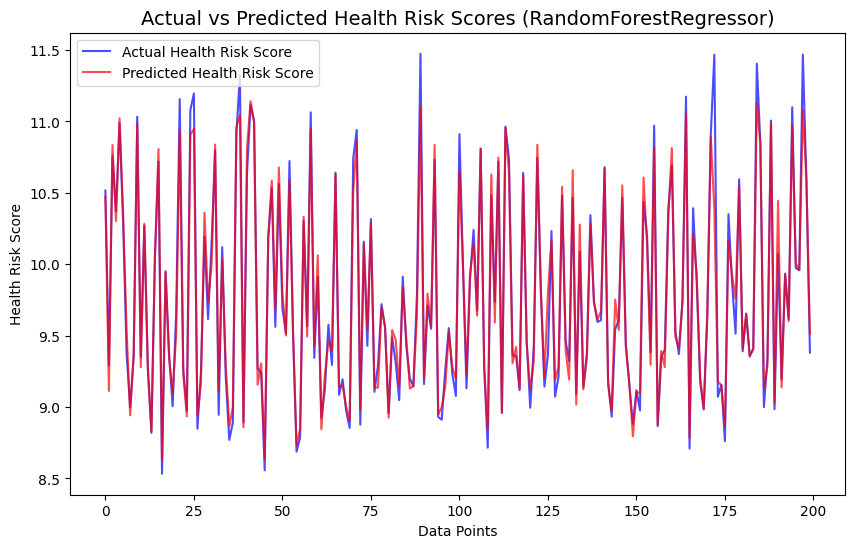

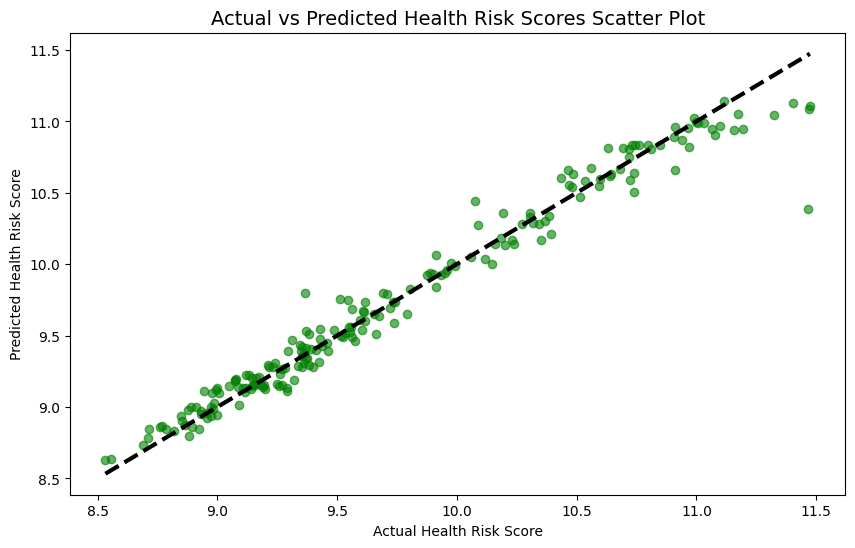

In [ ]:
#실제 값과 차이 출력

# 실제 값과 예측 값 비교 시각화
plt.figure(figsize=(10, 6))

# 실제 값과 예측 값의 차이를 막대 그래프로 표현
plt.plot(np.arange(len(y_test)), y_test, label='Actual Health Risk Score', color='blue', alpha=0.7)
plt.plot(np.arange(len(y_test)), y_pred_rf, label='Predicted Health Risk Score', color='red', alpha=0.7)

# 그래프 제목과 라벨 설정
plt.title('Actual vs Predicted Health Risk Scores (RandomForestRegressor)', fontsize=14)
plt.xlabel('Data Points')
plt.ylabel('Health Risk Score')
plt.legend()

# 시각화 출력
plt.show()

# 오차 분포 시각화
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.6, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)

# 그래프 제목과 라벨 설정
plt.title('Actual vs Predicted Health Risk Scores Scatter Plot', fontsize=14)
plt.xlabel('Actual Health Risk Score')
plt.ylabel('Predicted Health Risk Score')

# 시각화 출력
plt.show()

##2.2 XGBoost, GradientBoost, LightGBM, 랜덤포레스트 결과값 비교

In [ ]:
# 필요한 라이브러리 불러오기
from sklearn.metrics import mean_absolute_error, r2_score
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
import json

# 특성 및 타겟 데이터 설정 (분석에서 제외할 컬럼들 제거)
features = df.drop(columns = ['datetime', 'sunrise', 'sunset', 'preciptype', 'snowdepth', 'stations', 'Condition_Code', 'Health_Risk_Score' ,'conditions', 'description', 'icon', 'source', 'City', 'Season', 'Day_of_Week'])
target = df['Health_Risk_Score']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=29)

# 데이터 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# LightGBM 모델
lgbm_model = LGBMRegressor(random_state=29)
lgbm_model.fit(X_train_scaled, y_train)
y_pred_lgbm = lgbm_model.predict(X_test_scaled)
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)
r2_lgbm = r2_score(y_test, y_pred_lgbm)

# XGBoost 모델
xgb_model = XGBRegressor(random_state=29)
xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

# GradientBoosting 모델
gbr_model = GradientBoostingRegressor(random_state=29)
gbr_model.fit(X_train_scaled, y_train)
y_pred_gbr = gbr_model.predict(X_test_scaled)
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)

# 결과 출력
results = {
    'RandomForest': {'MAE': mae_rf, 'R²': r2_rf},
    'LightGBM': {'MAE': mae_lgbm, 'R²': r2_lgbm},
    'XGBoost': {'MAE': mae_xgb, 'R²': r2_xgb},
    'GradientBoosting': {'MAE': mae_gbr, 'R²': r2_gbr}
}

print(json.dumps(results, indent=4))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7143
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 29
[LightGBM] [Info] Start training from score 9.719476
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

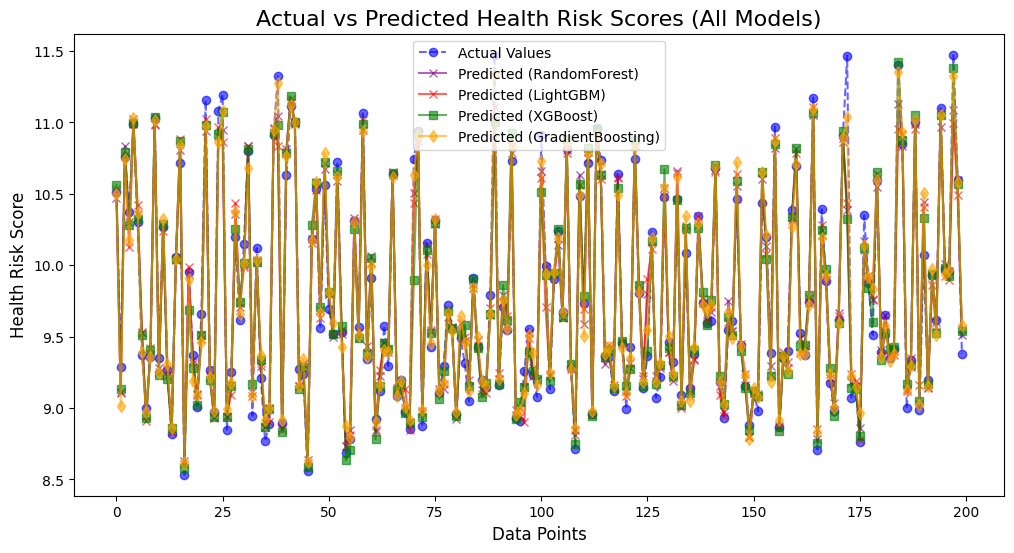

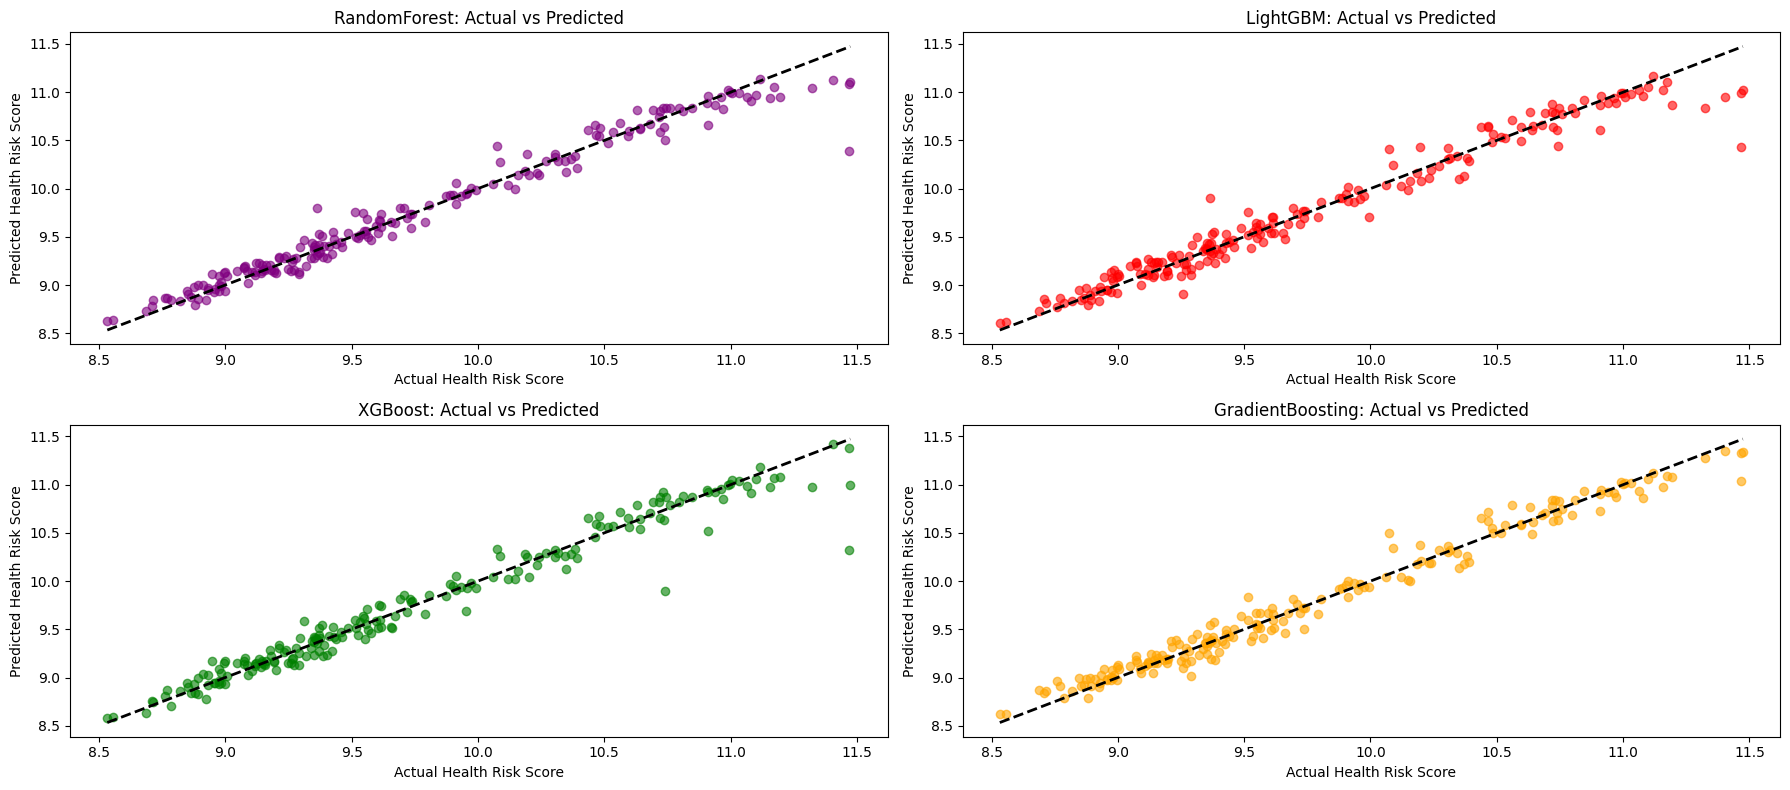

In [ ]:
# 1. 선형 그래프: 실제값 vs 예측값 (모든 모델 포함)
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(y_test)), y_test, label='Actual Values', color='blue', linestyle='--', marker='o', alpha=0.6)
plt.plot(np.arange(len(y_test)), y_pred_rf, label='Predicted (RandomForest)', color='purple', linestyle='-', marker='x', alpha=0.6)
plt.plot(np.arange(len(y_test)), y_pred_lgbm, label='Predicted (LightGBM)', color='red', linestyle='-', marker='x', alpha=0.6)
plt.plot(np.arange(len(y_test)), y_pred_xgb, label='Predicted (XGBoost)', color='green', linestyle='-', marker='s', alpha=0.6)
plt.plot(np.arange(len(y_test)), y_pred_gbr, label='Predicted (GradientBoosting)', color='orange', linestyle='-', marker='d', alpha=0.6)

# 그래프 제목과 라벨 설정
plt.title('Actual vs Predicted Health Risk Scores (All Models)', fontsize=16)
plt.xlabel('Data Points', fontsize=12)
plt.ylabel('Health Risk Score', fontsize=12)
plt.legend()
plt.show()

# 2. 산포도: 실제값 vs 예측값 (모든 모델 포함)
plt.figure(figsize=(18, 8))

# RandomForest
plt.subplot(2, 2, 1)
plt.scatter(y_test, y_pred_rf, color='purple', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('RandomForest: Actual vs Predicted')
plt.xlabel('Actual Health Risk Score')
plt.ylabel('Predicted Health Risk Score')

# LightGBM
plt.subplot(2, 2, 2)
plt.scatter(y_test, y_pred_lgbm, color='red', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('LightGBM: Actual vs Predicted')
plt.xlabel('Actual Health Risk Score')
plt.ylabel('Predicted Health Risk Score')

# XGBoost
plt.subplot(2, 2, 3)
plt.scatter(y_test, y_pred_xgb, color='green', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('XGBoost: Actual vs Predicted')
plt.xlabel('Actual Health Risk Score')
plt.ylabel('Predicted Health Risk Score')

# GradientBoosting
plt.subplot(2, 2, 4)
plt.scatter(y_test, y_pred_gbr, color='orange', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('GradientBoosting: Actual vs Predicted')
plt.xlabel('Actual Health Risk Score')
plt.ylabel('Predicted Health Risk Score')

# 그래프 레이아웃 설정
plt.tight_layout()
plt.show()

#3. Gradient Boost 모델 정확도 개선

##3.1 하이퍼파라미터 튜닝

In [ ]:
# Gradient Boosting 모델 초기화
gbr = GradientBoostingRegressor(random_state=29)

# 하이퍼파라미터 그리드 설정
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],          # 학습률
    'n_estimators': [100, 200, 500],             # 트리 개수
    'max_depth': [3, 5, 7],                      # 트리 최대 깊이
    'subsample': [0.8, 1.0],                     # 서브샘플링 비율
    'min_samples_split': [2, 5, 10]              # 노드를 분할하는 데 필요한 최소 샘플 수
}

# GridSearchCV 설정
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid,
                           cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

# 학습
grid_search.fit(X_train_scaled, y_train)

# 최적 하이퍼파라미터 출력
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

# 최적 모델로 예측 수행
best_gbr_model = grid_search.best_estimator_
y_pred_best_gbr = best_gbr_model.predict(X_test_scaled)

# 성능 평가
mae_best_gbr = mean_absolute_error(y_test, y_pred_best_gbr)
r2_best_gbr = r2_score(y_test, y_pred_best_gbr)

print(f"MAE (Best Model): {mae_best_gbr}")
print(f"R² (Best Model): {r2_best_gbr}")

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best parameters: {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 500, 'subsample': 0.8}
Best score: -0.012856410087359969
MAE (Best Model): 0.0832151399181711
R² (Best Model): 0.9735782475673213


##3.2 스케일링

In [ ]:
# 특성 및 타겟 데이터 설정 (분석에서 제외할 컬럼들 제거)
features = df.drop(columns = ['datetime', 'sunrise', 'sunset', 'preciptype', 'snowdepth', 'stations', 'Condition_Code', 'Health_Risk_Score' ,'conditions', 'description', 'icon', 'source', 'City', 'Season', 'Day_of_Week','Severity_Score',
'severerisk', 'visibility', 'cloudcover', 'precipcover','Month'])
target = df['Health_Risk_Score']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=29)

# 데이터 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# LightGBM 모델
lgbm_model = LGBMRegressor(random_state=29)
lgbm_model.fit(X_train_scaled, y_train)
y_pred_lgbm = lgbm_model.predict(X_test_scaled)
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)
r2_lgbm = r2_score(y_test, y_pred_lgbm)

# XGBoost 모델
xgb_model = XGBRegressor(random_state=29)
xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

# GradientBoosting 모델
gbr_model = GradientBoostingRegressor(random_state=29)
gbr_model.fit(X_train_scaled, y_train)
y_pred_gbr = gbr_model.predict(X_test_scaled)
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)

# 결과 출력
results = {
    'RandomForest': {'MAE': mae_rf, 'R²': r2_rf},
    'LightGBM': {'MAE': mae_lgbm, 'R²': r2_lgbm},
    'XGBoost': {'MAE': mae_xgb, 'R²': r2_xgb},
    'GradientBoosting': {'MAE': mae_gbr, 'R²': r2_gbr}
}

print(json.dumps(results, indent=4))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5868
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 24
[LightGBM] [Info] Start training from score 9.719476
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

#4. 제작된 모델로 데이터 제작

##4.1 파일 업로드 시 데이터 제작

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 15
[LightGBM] [Info] Start training from score 9.719476
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

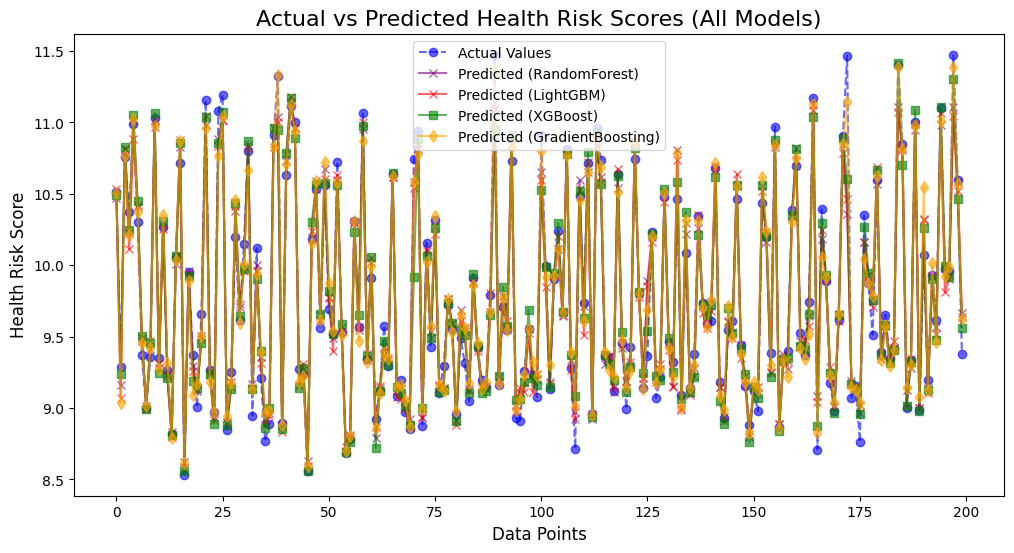

In [11]:
# Importing necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import xgboost as xgb
import lightgbm as lgb

# Step 1: Load the Urban Air Quality and Health Impact Dataset
url_dataset = "https://raw.githubusercontent.com/rich-hyun/5th-Static-Competition/main/Urban%20Air%20Quality%20and%20Health%20Impact%20Dataset.csv"
df = pd.read_csv(url_dataset)

# Step 2: Prepare the features by dropping unnecessary columns
features_updated = df[['temp', 'tempmin', 'tempmax', 'precip', 'windgust', 'winddir', 'windspeed', 'dew',
                       'humidity', 'pressure', 'solarradiation', 'snow', 'Temp_Range', 'feelslike', 'feelslikemax','Heat_Index']]

# Target variable (Health_Risk_Score)
target = df['Health_Risk_Score']

# Step 3: Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features_updated, target, test_size=0.2, random_state=29)

# Step 4: Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Train RandomForest model
rf_model = RandomForestRegressor(n_estimators=120, random_state=29)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

# Step 6: Train LightGBM model
lgbm_model = lgb.LGBMRegressor(random_state=29)
lgbm_model.fit(X_train_scaled, y_train)
y_pred_lgbm = lgbm_model.predict(X_test_scaled)

# Step 7: Train XGBoost model
xgb_model = xgb.XGBRegressor(random_state=29)
xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Step 8: Train GradientBoosting model
gbr_model = GradientBoostingRegressor(random_state=29)
gbr_model.fit(X_train_scaled, y_train)
y_pred_gbr = gbr_model.predict(X_test_scaled)

# Step 9: Evaluate all models using MAE and R2 Score
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)
r2_lgbm = r2_score(y_test, y_pred_lgbm)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)

# Step 10: Print model performance
print("RandomForest - MAE: {:.4f}, R2: {:.4f}".format(mae_rf, r2_rf))
print("LightGBM - MAE: {:.4f}, R2: {:.4f}".format(mae_lgbm, r2_lgbm))
print("XGBoost - MAE: {:.4f}, R2: {:.4f}".format(mae_xgb, r2_xgb))
print("GradientBoosting - MAE: {:.4f}, R2: {:.4f}".format(mae_gbr, r2_gbr))

# Visualize comparison of actual vs predicted for each model
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(y_test)), y_test, label='Actual Values', color='blue', linestyle='--', marker='o', alpha=0.6)
plt.plot(np.arange(len(y_test)), y_pred_rf, label='Predicted (RandomForest)', color='purple', linestyle='-', marker='x', alpha=0.6)
plt.plot(np.arange(len(y_test)), y_pred_lgbm, label='Predicted (LightGBM)', color='red', linestyle='-', marker='x', alpha=0.6)
plt.plot(np.arange(len(y_test)), y_pred_xgb, label='Predicted (XGBoost)', color='green', linestyle='-', marker='s', alpha=0.6)
plt.plot(np.arange(len(y_test)), y_pred_gbr, label='Predicted (GradientBoosting)', color='orange', linestyle='-', marker='d', alpha=0.6)

# Graph labels
plt.title('Actual vs Predicted Health Risk Scores (All Models)', fontsize=16)
plt.xlabel('Data Points', fontsize=12)
plt.ylabel('Health Risk Score', fontsize=12)
plt.legend()
plt.show()

In [7]:
#파일 업로드 후 결측치 확인
# Step 1: Upload file using Google Colab
from google.colab import files
import pandas as pd

# Prompt user to upload a file
uploaded = files.upload()  # This will open a file uploader window

# Load the uploaded CSV file into a DataFrame
df_uploaded = pd.read_csv(list(uploaded.keys())[0])

# Display the first few rows of the uploaded data
print("Uploaded file preview:")
df_uploaded.head()

Saving soeul3 최종.csv to soeul3 최종.csv
Uploaded file preview:


,datatime,temp,tempmin,tempmax,precip,windgust,winddir,windspeed,dew,humiditymin,humidity,pressure,solarradiation,snow,Temp_Range,feelslike,feelslikemax,feelslikemin,heat_index
0,2021-01-01,24.44,14.36,34.88,0.0,9.171454,603.9738,4.473880,-10.2,50,64.0,1014.9,2650.000002,0.0,20.52,24.44,30.934004,7.032156,200.998521
1,2021-01-02,23.00,16.88,29.48,0.0,12.079476,715.8208,5.816044,-17.1,29,38.5,1018.5,3150.000003,0.0,12.60,23.00,23.382850,8.412791,142.557055
2,2021-01-03,21.92,15.62,28.40,0.0,10.066230,603.9738,4.473880,-15.9,28,45.0,1023.0,2444.444446,0.0,12.78,21.92,23.386052,8.499814,164.677685
3,2021-01-04,25.70,16.88,32.54,0.0,7.158208,111.8470,3.802798,-12.2,38,51.4,1020.3,2066.666668,0.0,15.66,25.70,28.920773,10.898276,165.434661
4,2021-01-05,22.10,14.18,28.22,0.0,12.750558,648.7126,6.487126,-14.2,30,52.8,1019.2,2905.555558,0.0,14.04,22.10,21.332532,4.511397,185.581864


In [9]:
# Step 3: 결측치 확인
print("\n결측치 확인:")
missing_values = df_uploaded.isnull().sum()
print(missing_values)

# Step 4: 숫자형 열만 선택하여 결측치를 각 열의 평균값으로 대체
print("\n결측치를 각 열의 평균값으로 대체 중...")
numeric_columns = df_uploaded.select_dtypes(include=['float64', 'int64']).columns  # 숫자형 데이터만 선택
df_uploaded[numeric_columns] = df_uploaded[numeric_columns].fillna(df_uploaded[numeric_columns].mean())

# Step 5: 결측치가 잘 처리되었는지 다시 확인
print("\n결측치 처리 후:")
print(df_uploaded.isnull().sum())

# 처리된 데이터프레임 미리보기
print("\n처리된 데이터프레임 미리보기:")
print(df_uploaded.head())


결측치 확인:
datatime          0
temp              0
tempmin           1
tempmax           0
precip            0
windgust          2
winddir           2
windspeed         2
dew               0
humiditymin       0
humidity          0
pressure          0
solarradiation    3
snow              0
Temp_Range        1
feelslike         0
feelslikemax      0
feelslikemin      1
heat_index        0
dtype: int64

결측치를 각 열의 평균값으로 대체 중...

결측치 처리 후:
datatime          0
temp              0
tempmin           0
tempmax           0
precip            0
windgust          0
winddir           0
windspeed         0
dew               0
humiditymin       0
humidity          0
pressure          0
solarradiation    0
snow              0
Temp_Range        0
feelslike         0
feelslikemax      0
feelslikemin      0
heat_index        0
dtype: int64

처리된 데이터프레임 미리보기:
     datatime   temp  tempmin  tempmax  precip    windgust   winddir  \
0  2021-01-01  24.44    14.36    34.88      0.0   9.171454  603.9738   
1  2021

In [14]:
# 필요한 라이브러리 임포트
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from google.colab import files
import pandas as pd

# Step 1: Google Colab을 이용한 파일 업로드
uploaded = files.upload()  # 파일 업로드 창이 열립니다.

# 업로드한 파일을 데이터프레임으로 불러오기
df_uploaded = pd.read_csv(list(uploaded.keys())[0])

# Step 2: 결측치 처리 (숫자형 열만 처리)
numeric_columns = df_uploaded.select_dtypes(include=['float64', 'int64']).columns
df_uploaded[numeric_columns] = df_uploaded[numeric_columns].fillna(df_uploaded[numeric_columns].mean())

# Step 3: 학습 데이터 로드 및 준비 (Urban Air Quality and Health Impact Dataset)
url_dataset = "https://raw.githubusercontent.com/rich-hyun/5th-Static-Competition/main/Urban%20Air%20Quality%20and%20Health%20Impact%20Dataset.csv"
df = pd.read_csv(url_dataset)

# 학습용 데이터에서 필요한 변수 선택
features = df[['temp', 'tempmin', 'tempmax', 'precip', 'windgust', 'winddir', 'windspeed', 'dew',
               'humidity', 'pressure', 'solarradiation', 'snow', 'Temp_Range', 'feelslike', 'feelslikemax']]

# 타겟 변수 (Health_Risk_Score)
target = df['Health_Risk_Score']

# Step 4: 학습 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=29)

# 데이터 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: XGBoost 모델 학습
xgb_model = xgb.XGBRegressor(random_state=29)
xgb_model.fit(X_train_scaled, y_train)
# 데이터프레임의 열 이름 확인
print(df_uploaded.columns)

# Step 6: 업로드한 파일에서 예측에 사용할 변수 선택 및 스케일링
df_uploaded.columns = df_uploaded.columns.str.strip()
features_uploaded = df_uploaded[['temp', 'tempmin', 'tempmax', 'precip', 'windgust', 'winddir', 'windspeed', 'dew',
                                 'humidity', 'pressure', 'solarradiation', 'snow', 'Temp_Range', 'feelslike', 'feelslikemax']]

# 결측치 처리된 데이터에 대해 스케일링 적용
features_uploaded_scaled = scaler.transform(features_uploaded)

# Step 7: Health_Risk_Score 예측
df_uploaded['Predicted_Health_Risk_Score'] = xgb_model.predict(features_uploaded_scaled)

# Step 8: 예측 결과를 엑셀 파일로 저장
output_file = 'Seoul_Health_Risk_Predictions.xlsx'
df_uploaded.to_excel(output_file, index=False)

# Step 9: 엑셀 파일 다운로드
files.download(output_file)

Saving 21~23 seoul.csv to 21~23 seoul (2).csv
Index(['datatime', 'temp', 'tempmin', 'tempmax', 'precip ', 'windgust',
       'winddir', 'windspeed', 'dew ', 'humiditymin', 'humidity', 'pressure',
       'solarradiation', 'snow', 'Temp_Range', 'feelslike', 'feelslikemax',
       'feelslikemin', 'Heat_Index'],
      dtype='object')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>